# contour plot of foam scan data

In [1]:
using JuMP, Roots, PyPlot, Ipopt, DataFrames, NLopt, PyCall, Optim, Calculus
#@pyimport scipy.optimize as so
#PyPlot.rc("font", family="sans")
#PyPlot.rc("figure", figsize=(5,4))
@pyimport matplotlib.mlab as mlab
@pyimport scipy.interpolate as interps
@pyimport scipy.ndimage as scimage

INFO: Loading help data...


In [2]:
data1 = readtable("data_lowPT_AOS_analyzed.csv")
deleterows!(data1, [1,2,7,47,62,64])

,uw,ug,dp_ave,mu_gas,mu_water,mu_foam
1,1.763489674148425e-5,7.850235258951347e-6,7.681348082969433,1.8087723065739243e-5,0.0009537801460025846,0.3491520668143651
2,2.9391494569140415e-6,7.445380014638763e-6,10.7011094379085,1.8115253726238633e-5,0.0009537463759192275,1.1937298150590854
3,1.4695747284570208e-6,7.3827580780685635e-6,11.047093101587302,1.8119819893798986e-5,0.0009537408309505533,1.445620638776359
4,7.347873642285104e-7,1.1820563414304008e-5,11.057196430434782,1.8115070655984524e-5,0.0009537465985598759,1.020188051850802
5,7.347873642285104e-7,6.277403647695971e-6,7.07647410834236,1.8083894670119588e-5,0.0009537848888863743,1.1690342711849033
6,2.9391494569140415e-6,9.713494231121294e-6,12.034611721175587,1.8127474879100765e-5,0.0009537315700561279,1.101830687128639
7,2.9391494569140415e-6,1.8458654268164073e-5,15.057763648769576,1.815671856449678e-5,0.0009536965863816396,0.8151834149266508
8,2.9391494569140415e-6,5.038947040808932e-6,9.830293882943145,1.810756934519535e-5,0.0009537557431317811,1.4273526162134784
9,1.4695747284570208e-6,1.0631752725584448e-5,13.078648588679245,1.8142814319266176e-5,0.000953713142665395,1.2519699840945286
10,1.4695747284570208e-6,5.620260158917395e-6,10.450246524784482,1.811202056110418e-5,0.0009537503116599108,1.7074754705008592


In [3]:
L=0.17 # [m] core length
ug_all = float(data1[:ug])*3600*24 # [m/s]
uw_all = float(data1[:uw])*3600*24 # [m/s]
u_all = ug_all+uw_all # [m/s]
fg_exp_all = ug_all./u_all # [-]
dp_all = float(data1[:dp_ave])/L
# Foam apparent viscosity [Pa.s]
muf_exp_all = float(data1[:mu_foam]) # [Pa.s]
n_data = length(ug_all)
ind_u_mid=0.0000122*3600*24.<u_all.<0.000015*3600*24
u_mean=mean(u_all[ind_u_mid])
println("Data is loaded.")

Data is loaded.


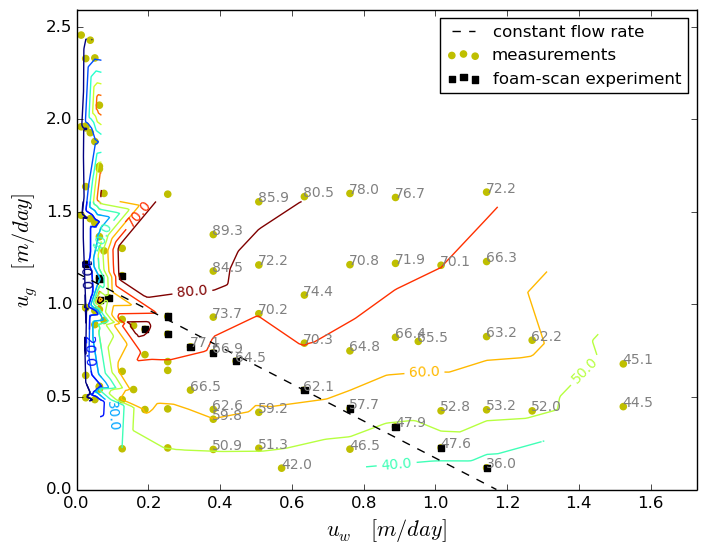

In [19]:
n_points=200
k=ones(5,5)/25.0
#low quality range
uw_all_high=0.0000008*3600*24
ind1=uw_all.<uw_all_high
uw1=linspace(minimum(uw_all), uw_all_high, n_points)
ug1=linspace(minimum(ug_all), maximum(ug_all), n_points)
#high quality range
ug_all_high=0.000018*3600*24
ind2=ug_all.<ug_all_high
uw2=linspace(minimum(uw_all), maximum(uw_all), n_points)
ug2=linspace(minimum(ug_all), ug_all_high, n_points)
dp1=mlab.griddata(uw_all, ug_all, dp_all, uw1, ug1, interp="linear")
dp1_fil= scimage.filters[:convolve](dp1,k)
dp2=mlab.griddata(uw_all, ug_all, dp_all, uw2, ug2, interp="linear")
#figure(figsize=(10,10))
#contourf(uw1,ug1,dp1,5)
c1=contour(uw1,ug1,dp1,5)
#contourf(uw2,ug2,dp2,10)
c2=contour(uw2,ug2,dp2,10)
clabel(c2,inline=1,fontsize=10, fmt="%r")
scatter(uw_all, ug_all, marker="o", color="y")
scatter(uw_all[ind_u_mid], ug_all[ind_u_mid], marker="s", color="k")
for i=1:length(uw_all)
    if uw_all[i]>0.3
        text(uw_all[i], ug_all[i], string(dp_all[i])[1:4], fontsize=10.0, color="0.50") #string(dp_all[i])[1:4]
    end
end
x=linspace(0,u_mean, 10)
y=u_mean-x
plot(x,y,"--k")
legend(["constant flow rate", "measurements", "foam-scan experiment"], fontsize=12)
xlabel(L"u_w\;[m/day]", fontsize=16)
ylabel(L"u_g\;[m/day]", fontsize=16)
axis([0,0.000020*3600*24,0,0.000030*3600*24])
savefig("full_foam_scan.png", dvi=300)

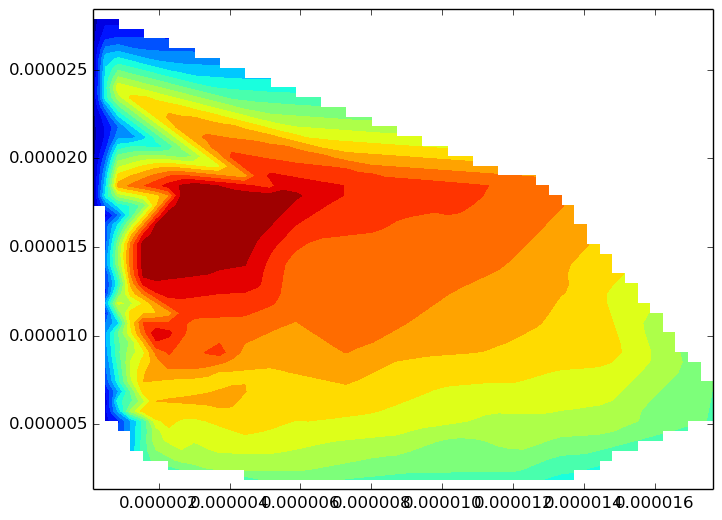

PyObject <matplotlib.contour.QuadContourSet instance at 0x7f24fdbe1cb0>

In [232]:
n_points=50
uw=linspace(minimum(uw_all), maximum(uw_all), n_points).*ones(n_points, n_points)
ug=linspace(minimum(ug_all), maximum(ug_all), n_points)'.*ones(n_points, n_points)
dp=interps.griddata((uw_all, ug_all), dp_all, (uw, ug), method="linear")
contourf(uw, ug, dp, 20)

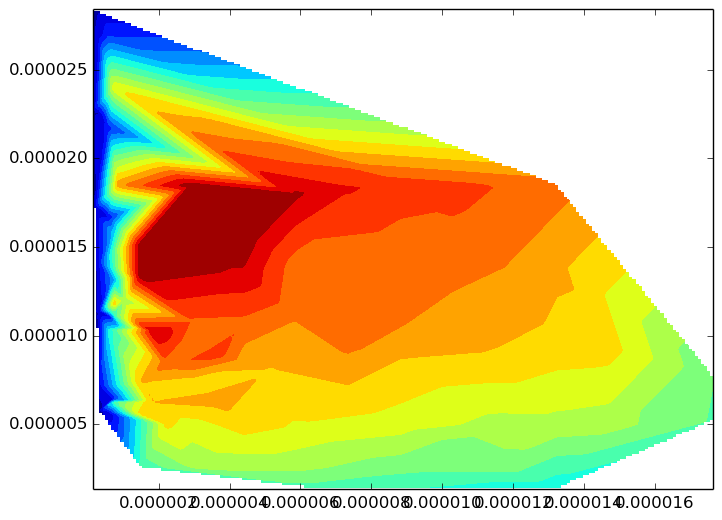

PyObject <matplotlib.contour.QuadContourSet instance at 0x7f24fd75ecf8>

In [235]:
n_points=200
uw=linspace(minimum(uw_all), maximum(uw_all), n_points)
ug=linspace(minimum(ug_all), maximum(ug_all), n_points)
dp=mlab.griddata(uw_all, ug_all, dp_all, uw, ug, interp="linear")
contourf(uw,ug,dp,20)